In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src.eval import calculate_rouge

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv("data/flores/test.csv")

scores = json.load(open("results/checkpoint-300_flores_scores", "r"))
with open("results/checkpoint-300_flores_sentences") as file:
    texts = [line.rstrip() for line in file]

In [3]:
metric = list[float]()
for pred, label in zip(texts, df["target"]):
    rouge = calculate_rouge(predictions=[pred], references=[[label]])["rougeL"]
    metric.append(rouge)

In [4]:
df_score = pd.DataFrame(
    {
        "rougel": metric,
        "cert_2": scores["99"],
    }
)

In [5]:
np.corrcoef(df_score["rougel"], df_score["cert_2"])

array([[1.        , 0.51908699],
       [0.51908699, 1.        ]])

Text(0.5, 1.0, 'FLORES (Filipino Set)')

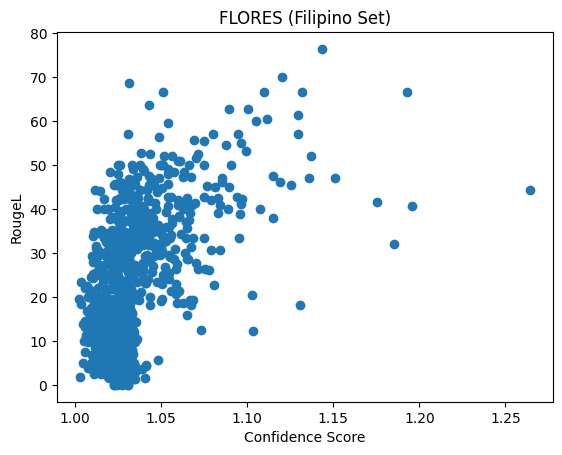

In [6]:
plt.scatter(y=df_score["rougel"], x=df_score["cert_2"])
plt.xlabel("Confidence Score")
plt.ylabel("RougeL")
plt.title("FLORES (Filipino Set)")

In [8]:
# plt.scatter(
#     y=df_score["bleu_2"] - df_score["bleu_1"], x=df_score["cert_2"] - df_score["cert_1"]
# )
# plt.vlines(x=0, ymin=-40, ymax=40)
# plt.hlines(y=0, xmin=-0.8, xmax=0.6)

/home/mila/f/floresl/miniconda3/envs/al/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mila/f/floresl/miniconda3/envs/al/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Text(0.5, 1.0, 'FLORES (Filipino Set)')

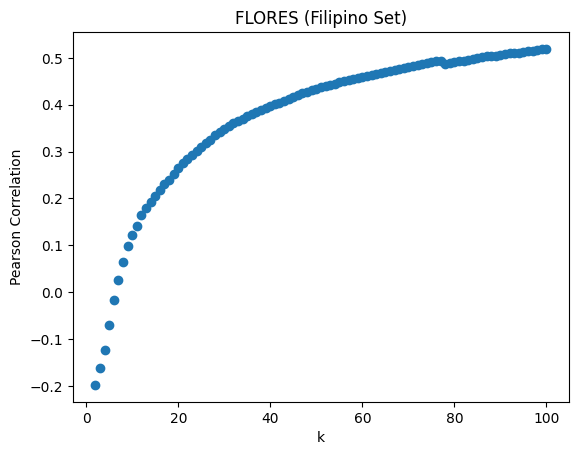

In [7]:
correlations = [
    np.corrcoef(df_score["rougel"], scores[str(k)])[0, 1] for k in range(100)
]
plt.scatter(x=list(range(1, 101)), y=correlations)
plt.xlabel("k")
plt.ylabel("Pearson Correlation")
plt.title("FLORES (Filipino Set)")